In [1]:
import os
import sys
import time
import pickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 999
pd.options.display.max_columns = 9999

In [3]:
data2 = pd.read_csv("esc_est2.csv", na_values = ["NaN", "NaN"], sep = ",")


## Agrupamos por escuela

In [4]:
data2 = data2.groupby(['CNTSCHID']).mean()

## Grabamos esta agrupación para el DASH

In [5]:
data2.to_csv("esc_est2_agru.csv")

In [6]:
##LECTURA DEL FICHERO SPSS Y SUS METADATOS
##Debe estar instalado el paquete de pyreadstat que permite leer ficheros SPSS y SAS
import pyreadstat

df, meta = pyreadstat.pyreadstat.read_sav('D:\TFM\Cuestionarios\CuestionariosEsp\Estudiantes\estudiantesESP1.sav', metadataonly=True)
df2, meta2 = pyreadstat.pyreadstat.read_sav('D:\TFM\Cuestionarios\CuestionariosEsp\Escuelas\Limpieza\escuelasESP1.sav', metadataonly=True)
df3, meta3 = pyreadstat.pyreadstat.read_sav('D:\TFM\Cuestionarios\CuestionariosEsp\profesores\Limpieza\profesoresESP1.sav', metadataonly=True)

## Variables a eliminar de entrada al modelo, como las target, los ID, las regiones, etc...

## Eliminamos las variables del curso al que van, ya que esta demasiado relacionado con el objetivo, y otras que esten demasiado relacionadas
## Como puede ser que hayan repetido

In [7]:

dataMod = data2.drop(['CNTSTUID','LECTURA1','MATES1','CIENCIA1','GLOBAL1','LECTURA2','MATES2','CIENCIA2','GLOBAL2','Unnamed: 0','Unnamed: 0.1','Unnamed: 0_x','Unnamed: 0_y','CCAA'],axis=1)

In [8]:

#dataMod = dataMod.drop(['ST001D01T_7.0','ST001D01T_8.0','ST001D01T_9.0','ST001D01T_10.0','ST001D01T_11.0','EFFORT1_1.0', 'REPEAT_0.0', 'REPEAT_1.0', 'GRADE_0.0', 'GRADE_-2.0', 'EFFORT2_7.0', 'EFFORT1_9.0', 'EFFORT1_2.0'],axis=1)

### <font color="#CA3532">Normalización de los datos</font>

La normalización de datos es muy importante, especialmente cuando se han medido diferentes atributos con diferentes escalas. Aplicamos la normalización solo a los atributos numéricos. Una forma de normalizar bastante común es la estandarización, que consiste en restar la media y escalar para tener una media igual a 0 y una desviación estándar igual a 1.

In [9]:
#dataMod = (dataMod - dataMod.mean()) / dataMod.std() # También se conoce como el "Z-Score"

## Modelo de regresion lineal y grafico de coeficiente de relacion

model intercept: 0.646429


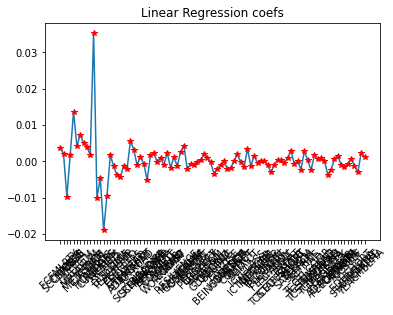

In [10]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()
x = std_sc.fit_transform(dataMod.values)
y = data2['GLOBAL1'].values
#y = data2['LECTURA1'].values
#y = data2['MATES1'].values
#y = data['CIENCIA1'].values
#y = data['GLOBAL2'].values
#y = data['LECTURA2'].values
#y = data['MATES2'].values
#y = data['CIENCIA2'].values


lr_m =  Ridge()
#ajuste sobre la muestra completa, sin split train-test
lr_m.fit(x, y)

print("model intercept: %f" % lr_m.intercept_)

nticks = len(lr_m.coef_)
plt.xticks(range(len(dataMod.columns.to_list())), dataMod.columns.to_list(), rotation=45)
plt.title('Linear Regression coefs')
_ = plt.plot(lr_m.coef_.T, '-', lr_m.coef_.T, 'r*')

 ## Paso para mediante los coeficientes de relación ver cuales influyen más

In [11]:
#Dataframe con el coeficiente y nombre columna
VarCoef = pd.DataFrame(lr_m.coef_.T,dataMod.columns.to_list()).sort_values(0)
VarCoef ['Cols']=VarCoef.index

#Dataframe con las descripciones (convertimos un diccionario a un DataFrame)
Des1 = pd.DataFrame([[key, meta.column_names_to_labels[key]] for key in meta.column_names_to_labels.keys()], columns=['Cols', 'Desc'])
Des2 = pd.DataFrame([[key, meta2.column_names_to_labels[key]] for key in meta2.column_names_to_labels.keys()], columns=['Cols', 'Desc'])
Des3 = pd.DataFrame([[key, meta3.column_names_to_labels[key]] for key in meta3.column_names_to_labels.keys()], columns=['Cols', 'Desc'])
Des = pd.concat([Des1,Des2, Des3],axis=0)


#Hacemos todos los cruces, para que crucen todas las columnas
VarCoef0 = pd.merge(left=Des,right=VarCoef, left_on='Cols', right_on='Cols')

VarCoef0["Coefi_abs"] = abs(VarCoef0[0])

In [12]:
VarImp = VarCoef0.sort_values("Coefi_abs", ascending=False)

In [13]:
## Nombre de la columna original
## Nombre de la columna transformada si se ha dicotomizado
## Descripcion de la columna original
## Coeficiente de relación
## Valor absoluto de coeficiente de relación

In [14]:
VarImp

,Cols,Desc,0,Coefi_abs
10,HOMEPOS,Home possessions (WLE),0.035406,0.035406
13,WEALTH,Family wealth (WLE),-0.018985,0.018985
4,ESCS,"Index of economic, social and cultural status",0.013611,0.013611
11,CULTPOSS,Cultural possessions at home (WLE),-0.010020,0.010020
2,CHANGE,Number of changes in educational biography (Sum),-0.009678,0.009678
14,ICTRES,ICT resources (WLE),-0.009472,0.009472
6,METASUM,Meta-cognition: summarising,0.007374,0.007374
21,ADAPTIVITY,Adaptation of instruction (WLE),0.005621,0.005621
26,PISADIFF,Perception of difficulty of the PISA test (WLE),-0.005118,0.005118
7,METASPAM,Meta-cognition: assess credibility,0.004984,0.004984


## Generación del modelo entrenandolo con datos de entrenamiento y probandolo con test

In [15]:
# training /test split
from sklearn.model_selection import train_test_split
testsize = 0.2 # in the [0,1] range. 1: 100%
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=testsize, random_state=1)

model intercept: 0.647455


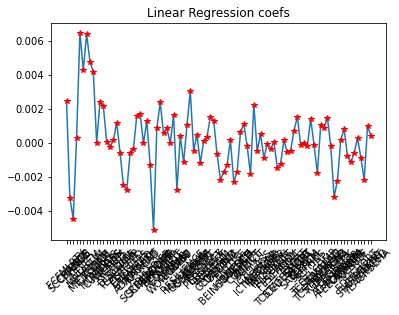

In [26]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


lr_m =  Ridge(alpha=256.00)
#ajuste sobre la muestra completa, sin split train-test
lr_m.fit(X_train, y_train)

print("model intercept: %f" % lr_m.intercept_)

nticks = len(lr_m.coef_)
plt.xticks(range(len(dataMod.columns.to_list())), dataMod.columns.to_list(), rotation=45)
plt.title('Linear Regression coefs')
_ = plt.plot(lr_m.coef_.T, '-', lr_m.coef_.T, 'r*')


## Prueba del modelo de todos los datos

MAE: 0.018	R^2: 0.774


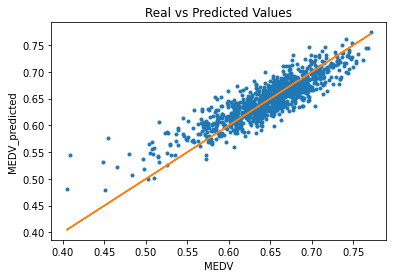

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = np.clip(lr_m.predict(x), 0,  100.)

print("MAE: %.3f\tR^2: %.3f" % (mean_absolute_error(y, y_pred), lr_m.score(x, y)))

plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

## Resultado con los datos de entrenamiento

MAE: 0.017	R^2: 0.793


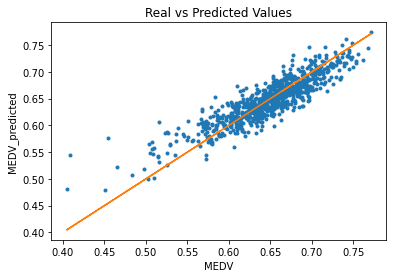

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = np.clip(lr_m.predict(X_train), 0,  100.)

print("MAE: %.3f\tR^2: %.3f" % (mean_absolute_error(y_train, y_pred), lr_m.score(X_train, y_train)))

plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y_train, y_pred, '.', y_train, y_train, '-')

## Resultado con los datos de test

MAE: 0.020	R^2: 0.678


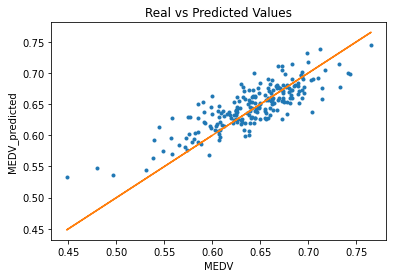

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = np.clip(lr_m.predict(X_test), 0,  100.)

print("MAE: %.3f\tR^2: %.3f" % (mean_absolute_error(y_test, y_pred), lr_m.score(X_test, y_test)))

plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y_test, y_pred, '.', y_test, y_test, '-')

## Gridearch para buscar el mejor alpha

In [24]:
# select alpha in ridge regression by CV
# First iteration to find alpha
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

# define folds
n_folds = 10
kf = KFold(n_folds, shuffle=True)

# define param_grid
l_alpha = [2.**k for k in range(-6, 10)]
param_grid = {'alpha': l_alpha}

# define grid search
lr_m = Ridge()
ridge_alpha_search = GridSearchCV(lr_m, 
                                  param_grid=param_grid, 
                                  cv=kf, 
                                  scoring='neg_mean_absolute_error',
                                  n_jobs=2, 
                                  verbose=1)

_ = ridge_alpha_search.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


alpha_range: 0.02 - 512.00
alpha = 256.00
best_cv_mae = 0.019


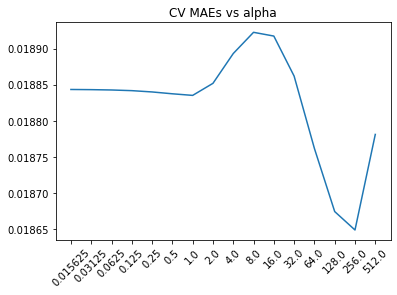

In [25]:
print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('alpha = %.2f' % (ridge_alpha_search.best_params_['alpha']))
print('best_cv_mae = %.3f' % (-ridge_alpha_search.best_score_))

plt.title("CV MAEs vs alpha")
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -ridge_alpha_search.cv_results_['mean_test_score'])